# Example plots using IDEAL Home Energy Dataset metadata and survey data

### About
* Authors: Martin Pullinger, Jonathan Kilgour, University of Edinburgh, School of Informatics.
* Date: May 2020

### Purpose
This script provides simple code examples to demonstrate how to:
* 1) access and use metadata and survey response data from the IDEAL Home Energy Dataset
* 2) make use of the file 'survey_response_wordings.csv' to aid data analysis.

### Inputs
Source data and supporting files come from the following tables from the IDEAL Home Energy Dataset (store them in a sub-directory called 'Data'):
* home.csv
* person.csv
* survey_responses.csv
* survey_response_wordings.csv

Note this is tested with Python 3.x.

### Outputs
* Plots of data as demonstrated in 2) below.

---
## 0) Setup

In [18]:
import os
cwd = os.getcwd()
import datetime
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from IdealMetadataInterface import IdealMetadataInterface

## 1) Import data

Set your paths as appropriate

In [19]:
metadatapath = '../../metadata'
surveypath = '../../surveys'

mdi = IdealMetadataInterface(metadatapath)
survey_responses = pd.read_csv(os.path.join(surveypath,'survey_responses.csv'))
survey_response_wordings = pd.read_csv(os.path.join(surveypath,'survey_response_wordings.csv'))

---
## 2) Example data plots
### Occupancy counts
This uses data from home.csv

In [20]:
# Relabel homes with missing occupants
home = mdi.metadata.homes['home']
person = mdi.metadata.people['person']
home_plots = home.copy()
home_plots.residents = home_plots.residents.astype(str)
home_plots.residents.replace('0','No data', regex=True, inplace=True)

In [21]:
# Sort the data for plotting
home_plots.sort_values(by='residents', ascending=True, inplace=True)

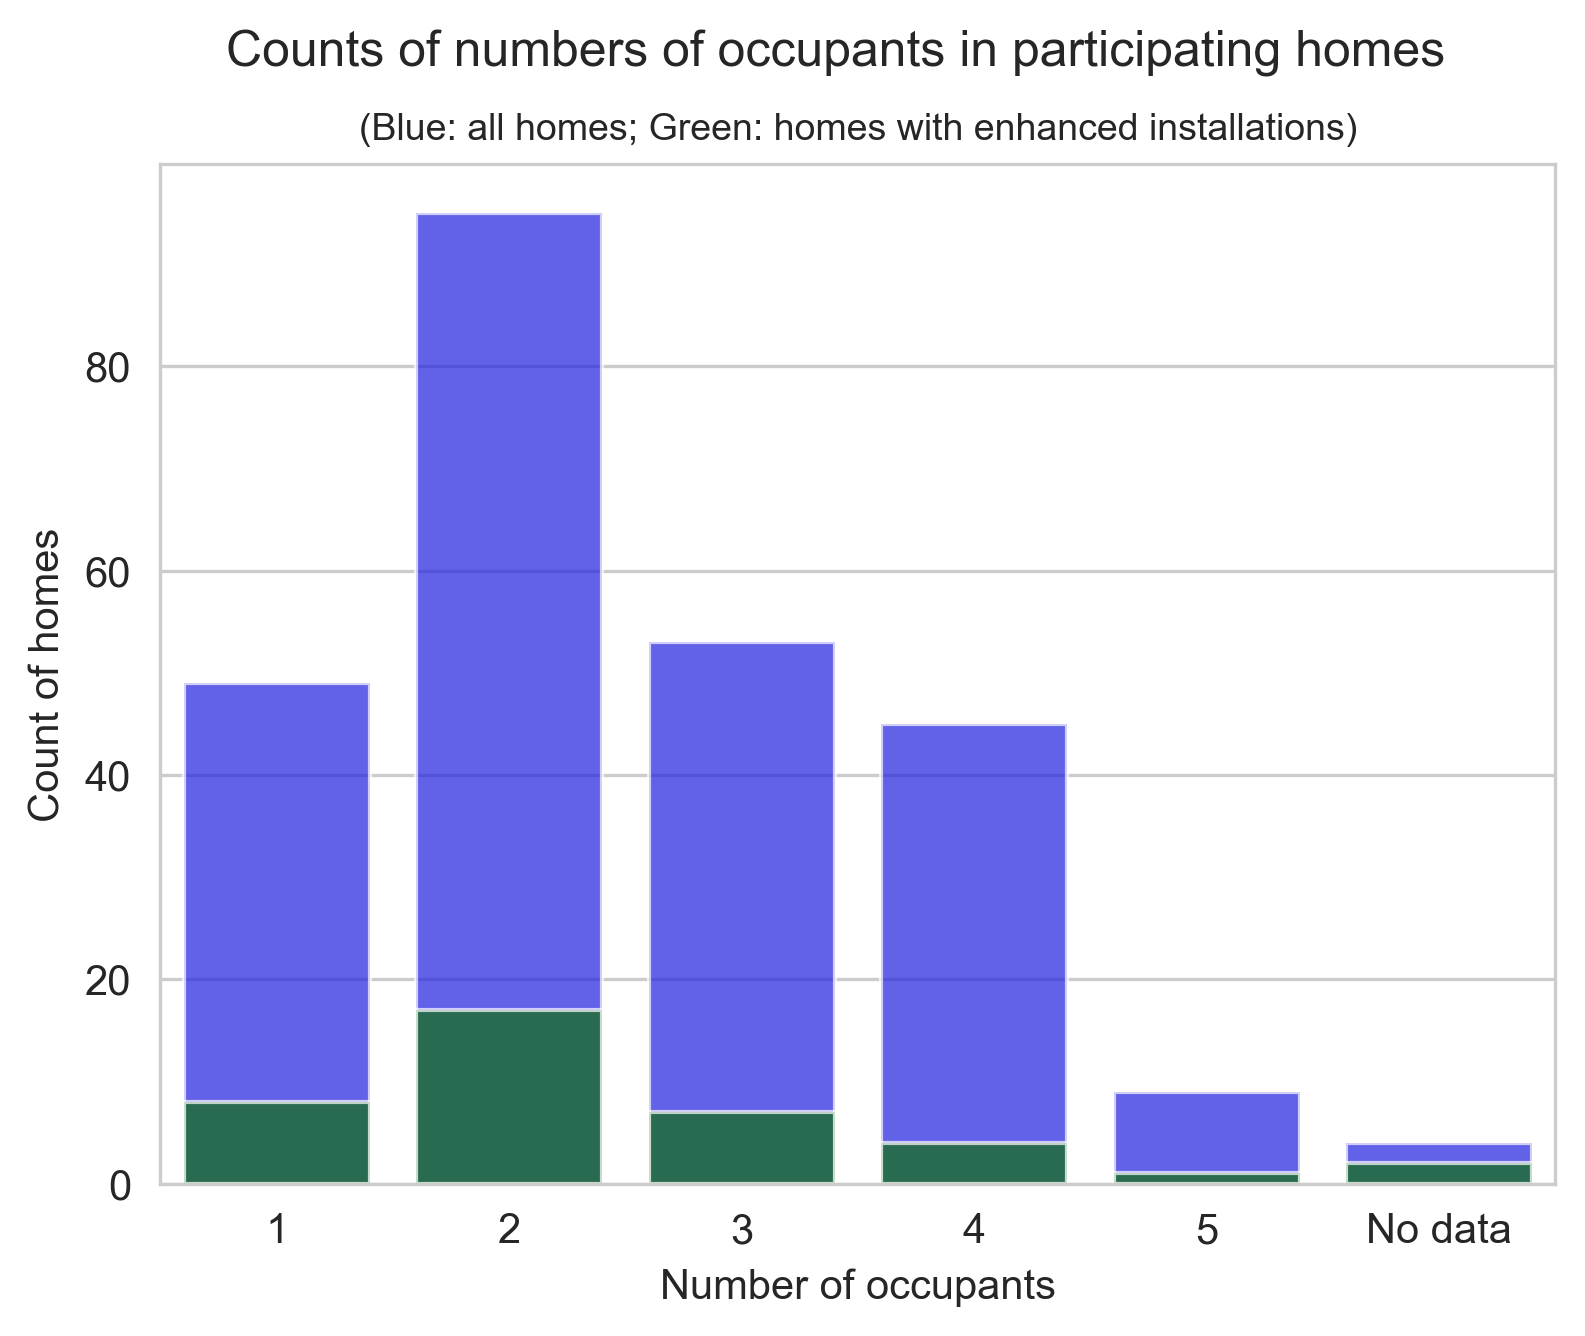

In [22]:
# Plot the data
fig = plt.figure(figsize = (6,4.5),dpi=300) 
ax = fig.add_subplot(111) 
sns.set_style('whitegrid') 
ax = sns.countplot(x="residents", data=home_plots, color='blue',alpha=0.7)
ax = sns.countplot(x="residents", data=home_plots[home_plots.install_type=="enhanced"], color='green',alpha=0.7)
ax.set(ylabel="Count of homes", xlabel="Number of occupants")
fig.suptitle("Counts of numbers of occupants in participating homes", fontsize=12)
ax.set_title("(Blue: all homes; Green: homes with enhanced installations)", fontsize=9)
plt.show()

### Age bands of primary participants
This uses:
* data from person.csv and home.csv
* survey_response_wordings.csv to order the age bands correctly

In [23]:
# Add in the install_type to person table
person = pd.merge(person,home[["homeid","install_type"]],on="homeid",how="left")

In [24]:
# Sort data by ageband
# Use survey_response_wordings to set the correct order for ageband responses
agedband_order = survey_response_wordings[survey_response_wordings.uniquequestionid=='ageband'].response_wording.tolist()
agedband_order.append('No data')

# Convert any missing data to 'No data'
person.loc[person.ageband.isnull(),"ageband"]="No data"
# Convert to a categorical using the ageband order
person['ageband'] = pd.Categorical(person['ageband'], agedband_order)
person.sort_values(by='ageband', ascending=True,inplace=True)

In [25]:
# Precalculate the summary data for the plot
# For all homes
groupby_object_all = person[person.primaryparticipant==1].groupby(['ageband'])
ageband_summary_all = groupby_object_all[['primaryparticipant']].count()
ageband_summary_all.rename(columns={"primaryparticipant": "count_all_pps"},inplace=True)

In [26]:
# For enhanced homes
groupby_object_enhanced = person[(person.primaryparticipant==1) & (person.install_type=="enhanced")].groupby(['ageband'])
ageband_summary_enhanced = groupby_object_enhanced[['primaryparticipant']].count()
ageband_summary_enhanced.rename(columns={"primaryparticipant": "count_enhanced_pps"},inplace=True)

In [27]:
# Join the two
ageband_summary=pd.merge(ageband_summary_all, ageband_summary_enhanced["count_enhanced_pps"], on="ageband", how="outer")
ageband_summary.replace(np.nan,0,inplace=True)

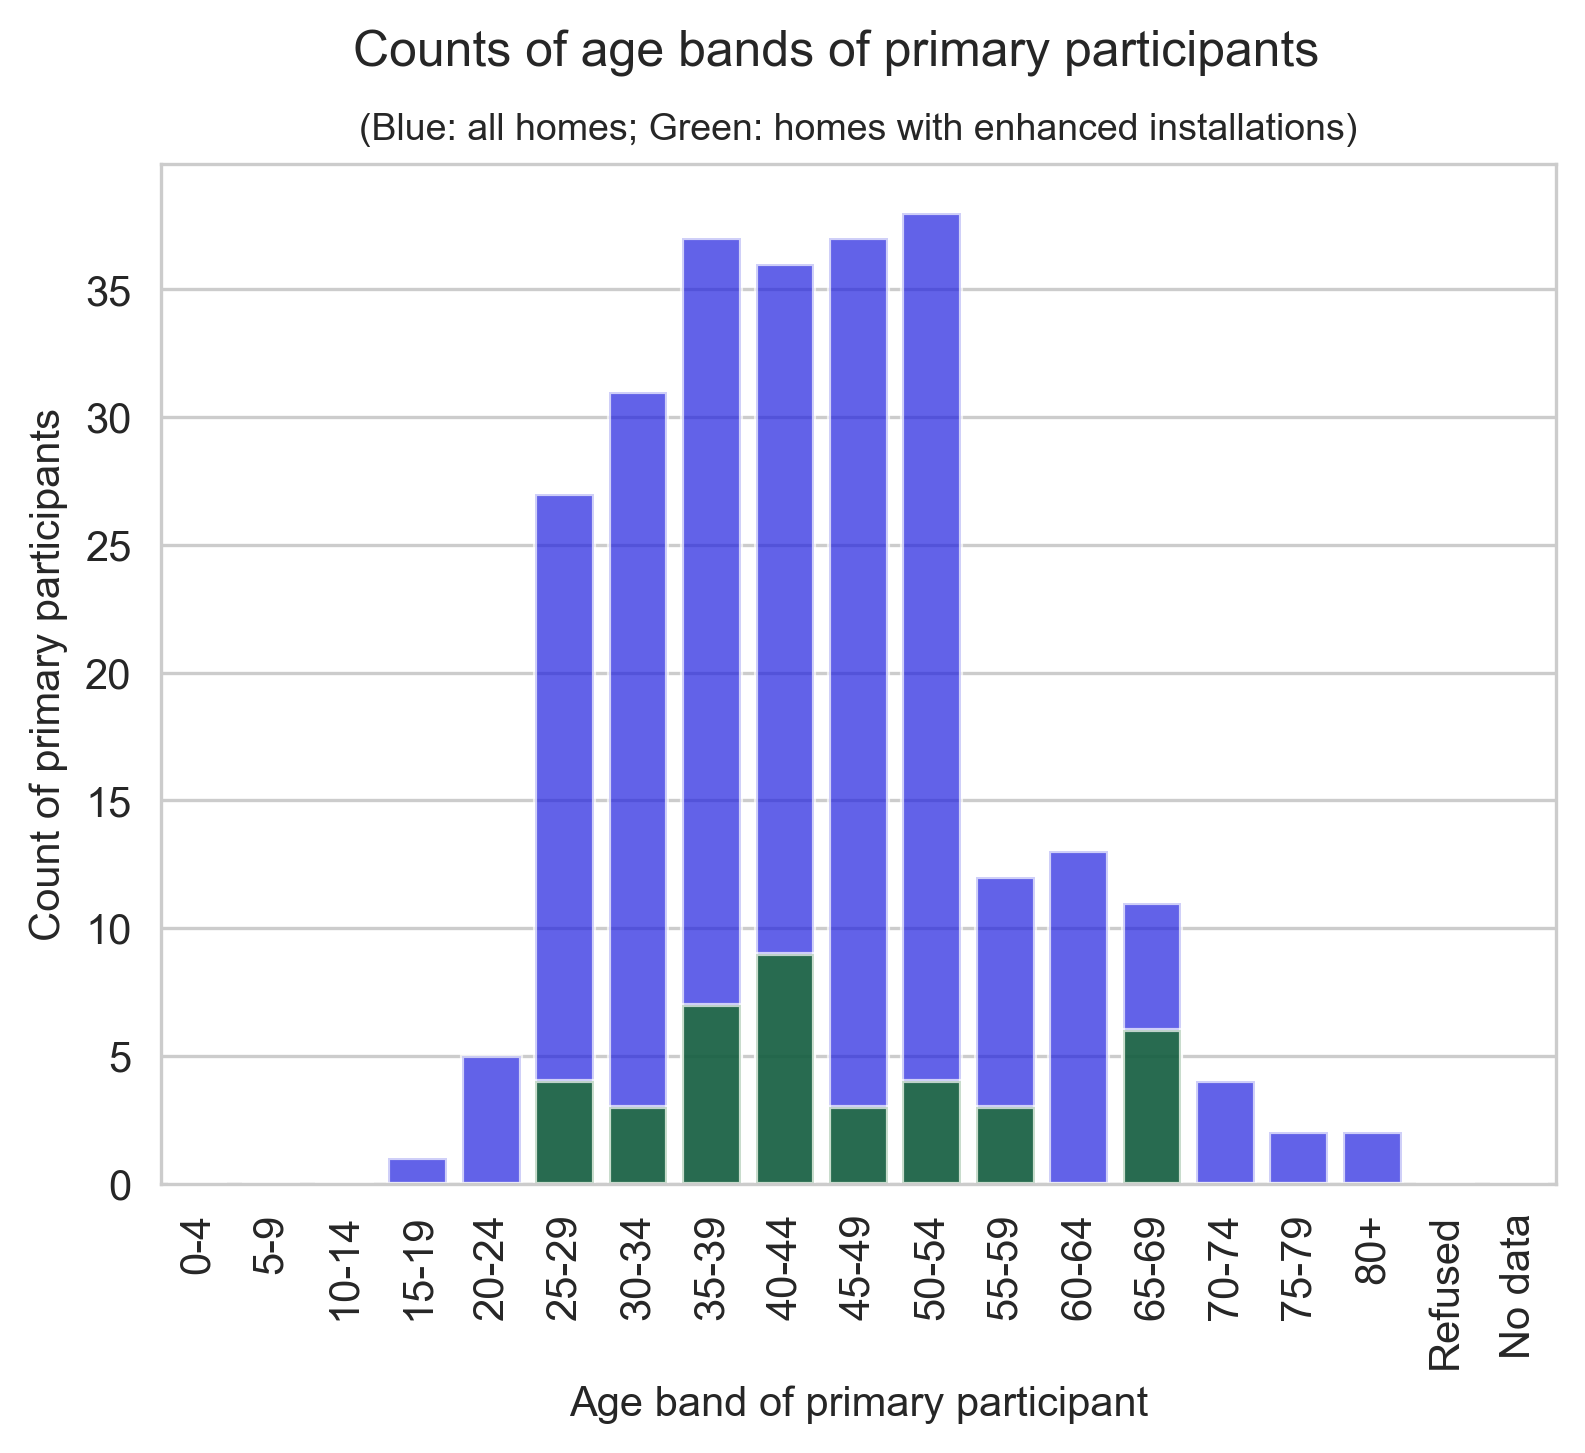

In [28]:
# Plot the data
fig = plt.figure(figsize = (6,4.5),dpi=300) 
ax = fig.add_subplot(111) 
sns.set_style('whitegrid') 
ax = sns.barplot(x=ageband_summary.index, y="count_all_pps", data=ageband_summary, color='blue',alpha=0.7)
ax = sns.barplot(x=ageband_summary.index, y="count_enhanced_pps", data=ageband_summary, color='green',alpha=0.7)
ax.set(ylabel="Count of primary participants", xlabel="Age band of primary participant")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.suptitle("Counts of age bands of primary participants", fontsize=12)
ax.set_title("(Blue: all homes; Green: homes with enhanced installations)", fontsize=9)
plt.show()

### Helping the environment
At the start of the project, how did primary participants respond to the question:

"Which of these statements best describes how you feel about your day-to-day life in the home and the environment?"

Variable: outcome_norm_env_1c_initial

This uses:
* data from survey_responses.csv and person.csv
* survey_response_wordings.csv to order the response options as they appeared in the survey

In [29]:
# Add in the primaryparticipant variable to the survey_responses table
survey_responses = pd.merge(survey_responses,person[["personid","primaryparticipant"]],on="personid",how="left")

In [30]:
# Sort data by the original order of response options
# Use survey_response_wordings to set the correct order
response_order = survey_response_wordings[survey_response_wordings.uniquequestionid=='outcome_norm_env_1c_initial'].response_wording.tolist()

# Convert to a categorical using the 
survey_responses['outcome_norm_env_1c_initial'] = pd.Categorical(survey_responses['outcome_norm_env_1c_initial'], response_order)
survey_responses.sort_values(by='outcome_norm_env_1c_initial',inplace=True)

In [31]:
# Precalculate the summary data for the plot
groupby_object_all = survey_responses[survey_responses.primaryparticipant==1].groupby(['outcome_norm_env_1c_initial'])
home_and_env_summary_all = groupby_object_all[['primaryparticipant']].count()
home_and_env_summary_all.rename(columns={"primaryparticipant": "count_all_pps"},inplace=True)

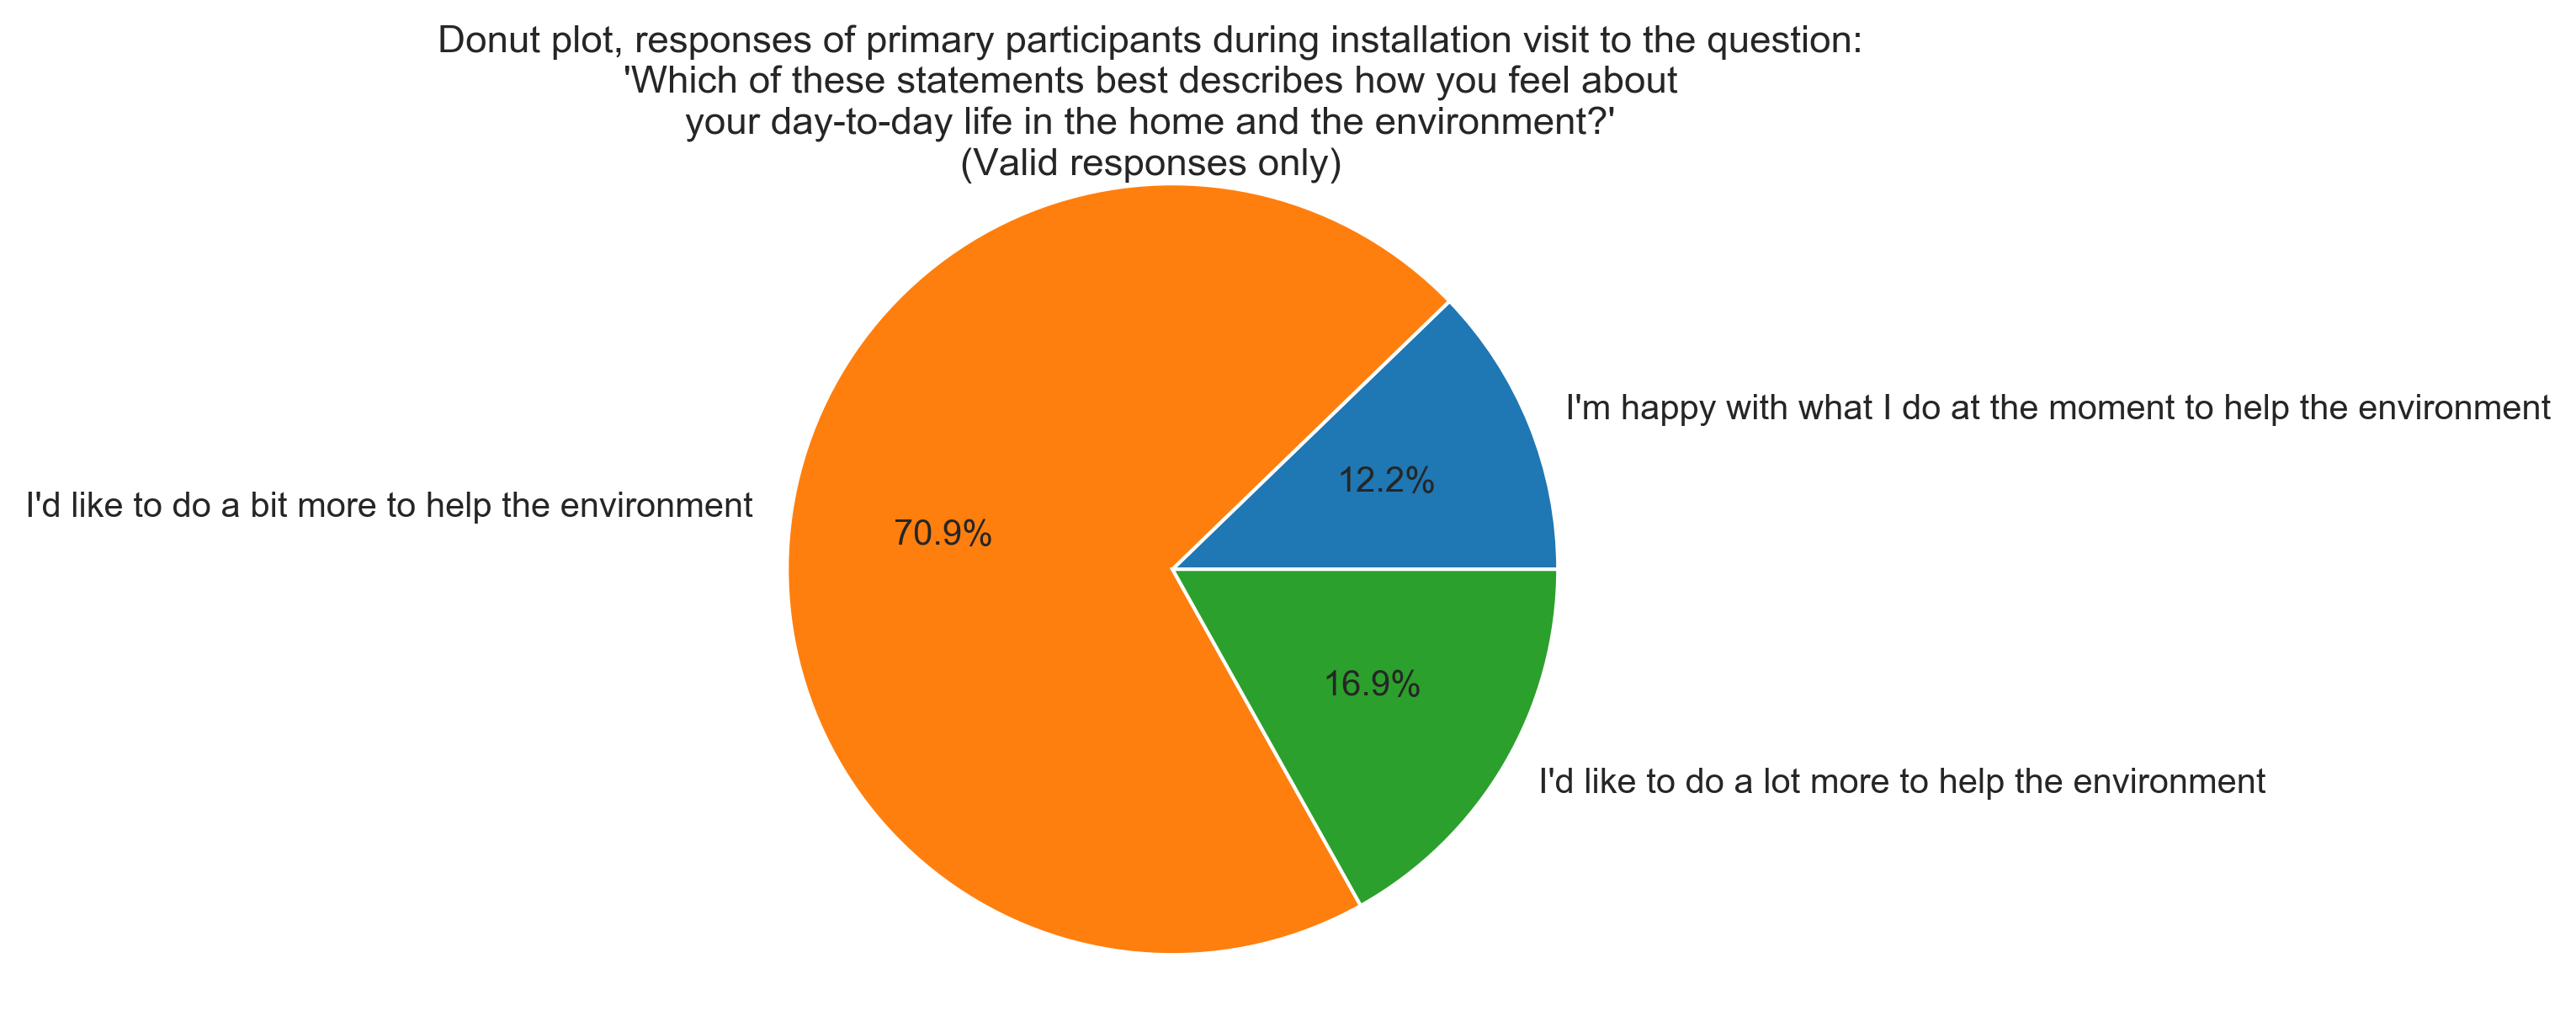

In [32]:
# Plot how primary participants responded to outcome_norm_env_1c_initial
fig = plt.figure(figsize = (6,4.5),dpi=300) 
ax = fig.add_subplot(111) 
ax.pie(home_and_env_summary_all.count_all_pps, labels=home_and_env_summary_all.index, autopct='%1.1f%%',
        shadow=False, startangle=0)
ax.axis('equal')
fig.suptitle("Donut plot, responses of primary participants during installation visit to the question:\n'Which of these statements best describes how you feel about\nyour day-to-day life in the home and the environment?'\n(Valid responses only)", fontsize=11)
plt.show()